In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from buffer import MultiModelActivationBuffer

from datasets import load_dataset
import torch as t

from nnsight import LanguageModel
from buffer import MultiModelActivationBuffer
from trainers.top_k import TopKTrainer, AutoEncoderTopK
from training import trainSAE
from einops import rearrange, einsum
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda:0"
dtype = t.bfloat16
t.set_grad_enabled(False)

In [2]:
layer = 4
out_batch_size = 4*4096

submodule_list = []
model_list = []
for step in [1, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 143000]:
    model = LanguageModel(
        "EleutherAI/pythia-70m", 
        revision=f"step{step}", 
        trust_remote_code=False, 
        device_map=device,
        torch_dtype=dtype,
        )
    for x in model.parameters():
        x.requires_grad = False
    model_list.append(model)
    submodule_list.append(model.gpt_neox.layers[layer])
    
activation_dim = 512

dataset = load_dataset(
    'Skylion007/openwebtext', 
    split='train', 
    streaming=True,
    trust_remote_code=True
    )

class CustomData():
    def __init__(self, dataset):
        self.data = iter(dataset)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.data)['text']

data = CustomData(dataset)

buffer = MultiModelActivationBuffer(
    data=data,
    model_list=model_list,
    submodule_list=submodule_list,
    d_submodule=activation_dim, # output dimension of the model component
    n_ctxs=256,  # you can set this higher or lower dependong on your available memory
    device=device,
    refresh_batch_size=128,
    out_batch_size=out_batch_size,
    remove_bos=True
)  # buffer will yield batches of tensors of dimension = submodule's output dimension

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [3]:
def concat(x):
    return rearrange(x, 'b n d -> b (n d)')
def unconcat(x):
    return rearrange(x, 'b (n d) -> b n d', n=len(model_list))

In [4]:
ae = AutoEncoderTopK.from_pretrained("/root/features_over_time/checkpoints/trainer_0/ae.pt", k=128, device=device)
dec = rearrange(ae.decoder.weight, "(n_models d) d_hid -> d_hid n_models d", n_models=len(model_list))
dec.shape

/root/features_over_time/notebooks/../trainers/top_k.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(path)


torch.Size([4096, 12, 512])

In [5]:
buffer.rescale_acts = True
buffer.act_mean = ae.act_mean.cpu()
buffer.act_std = ae.act_std.cpu()

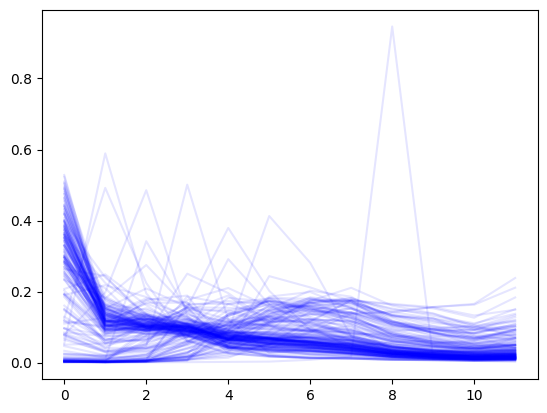

In [6]:
power = dec.pow(2).sum(-1)
power.shape
for i in range(200):
    plt.plot(power[i].detach().cpu(), color='blue', alpha=0.1)

In [7]:
# ae = AutoEncoderTopK.from_hf("jacobcd52/features_over_time", k=128, device=device)
# dec = rearrange(ae.decoder.weight, "(n_models d) d_hid -> d_hid n_models d", n_models=len(model_list))
# dec.shape
# power = dec.pow(2).sum(-1)
# power.shape
# for i in range(200):
#     plt.plot(power[i].detach().cpu(), color='blue', alpha=0.1)

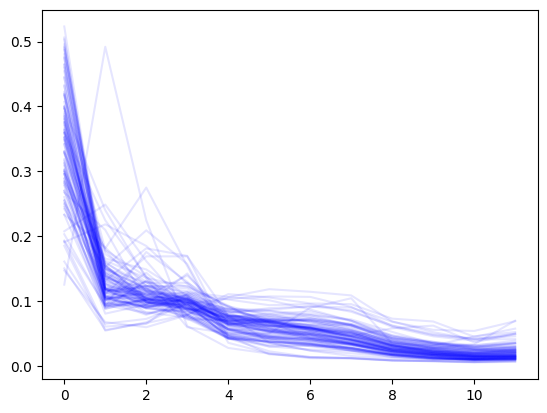

In [8]:
cpower = power.cumsum(-1)
# find the indices where the cumsum first exceeds 0.5
appear = (cpower > 0.2).float().argmax(-1)
is_dataset_feature = power.argmax(-1) < 2
is_dataset_feature.float().mean()
dataset_power = power[is_dataset_feature]
new_power = power[~is_dataset_feature]
for i in range(100):
    plt.plot(dataset_power[i].detach().cpu(), color='blue', alpha=0.1)

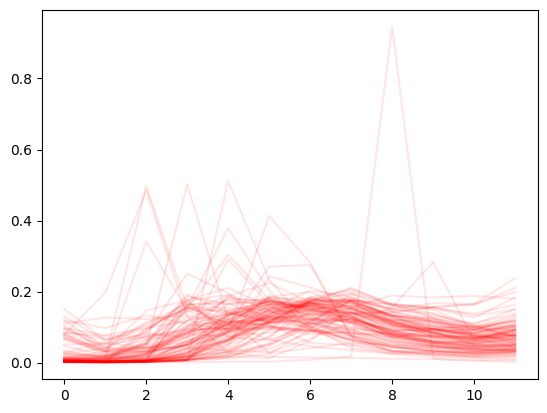

In [9]:
for i in range(100):
    plt.plot(new_power[i].detach().cpu(), color='red', alpha=0.1)

(0.0, 0.3)

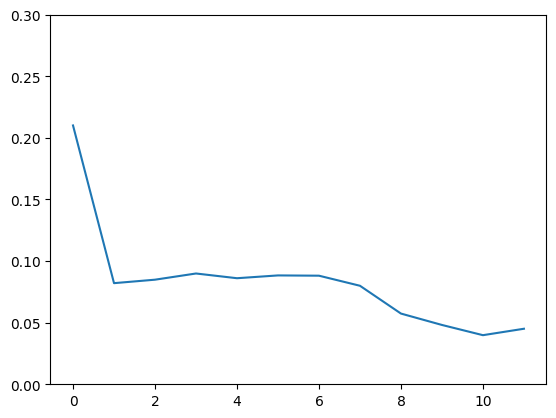

In [10]:
mean_power = power.mean(0)
plt.plot(mean_power.detach().cpu())
# set y lim
plt.ylim(0, 0.3)

In [11]:
n_batches = 1
overall_fvu = 0
fvu = t.zeros(len(model_list)).cuda()

for _ in tqdm(range(n_batches)):
    x = next(buffer)
    x_hat = ae(x)
    overall_fvu += (x - x_hat).var(0).sum() / x.var(0).sum()

    # now per checkpoint
    x = unconcat(x)
    x_hat = unconcat(x_hat)
    fvu += (x - x_hat).var(0).sum(-1) / x.var(0).sum(-1)

    print(x.var(0).sum(-1))

overall_fvu /= n_batches
fvu /= n_batches

100%|██████████| 1/1 [00:13<00:00, 13.40s/it]

tensor([1.0005, 0.9991, 1.0032, 1.0025, 0.9973, 0.9951, 0.9974, 0.9948, 0.9817,
        0.9731, 0.9770, 0.9806], device='cuda:0')


In [34]:
buffer.act_mean.shape

torch.Size([12, 512])

In [12]:
overall_fvu, fvu

(tensor(0.1536, device='cuda:0'),
 tensor([0.1713, 0.0674, 0.1044, 0.1679, 0.2008, 0.2033, 0.1987, 0.1852, 0.1441,
         0.1305, 0.1193, 0.1488], device='cuda:0'))

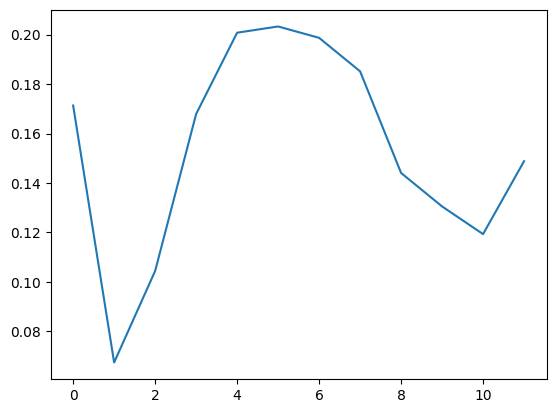

In [13]:
plt.plot(fvu.detach().cpu())
# set y range